In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import matplotlib.image as mpimg
from numpy import linalg as LA
import math 
import librosa
import warnings
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from IPython.display import display
warnings.filterwarnings("ignore")
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils

In [2]:
data_path = r'D:\uni lectures\term 8\archive (1)\Crema' 
#listing the file in the directory
audios = os.listdir(data_path) 
dict = {'SAD' : 'sadness', 'ANG': 'angry','DIS' : 'disgust','FEA' : 'fear','HAP': 'happy','NEU':'neutral'} 
emotions = []
audio_paths = []
for audio in audios:
    audio_paths.append( data_path +"\\"+ audio)
    #spliting the path at -
    prfxs =audio.split('_')
    #the third location contain sad or and or other emotion in dic
    emotions.append(dict[prfxs[2]])
    
#print(audio_paths[0])
#C:\Users\Dell\Downloads\archive (1)\crema1001_DFA_ANG_XX.wav
print(len(emotions))
#Crema_df=pd.DataFrame.from_dict(audio_paths)
#Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
#Crema_df.head()

7442


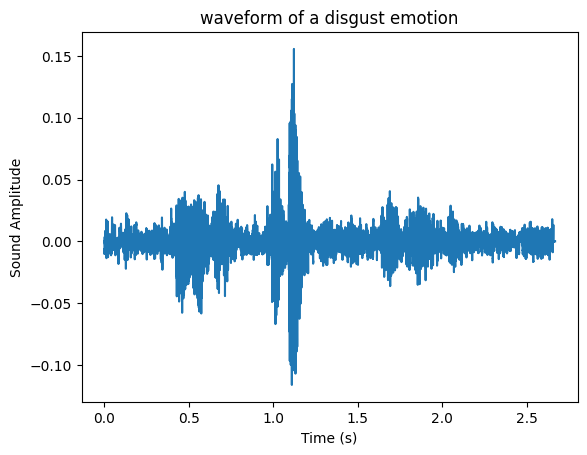

(58859,)


In [3]:
def waveform(path , emotion):
    audio,sr = librosa.load(path)
    #sr sampling rate
    time = np.arange(0 , len(audio)) / sr
    fig , ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = "Time (s)" , ylabel = "Sound Amplitude")
    plt.title("waveform of a " + emotion +" emotion")
    plt.show()
    display(Audio(path))
    print(audio.shape)
waveform(audio_paths[1000],emotions[1000])

In [4]:
audioTimeSeries = []
maxLen =0
for path in audio_paths:
        singleAudio, sr = librosa.load(path)
        maxLen = max(maxLen,len(singleAudio))
        audioTimeSeries.append(singleAudio)
# padding         
for i in range(len(audioTimeSeries)):
    audioTimeSeries[i] = np.pad(audioTimeSeries[i], (0, maxLen-len(audioTimeSeries[i])), 'constant')
    

In [5]:
#converting the whole data from list to numpy array so we can calculte the needed features
audioTimeSeries=np.array(audioTimeSeries)


In [6]:
print(np.shape(audioTimeSeries))

(7442, 110361)


In [7]:
# def getTwoFeatureSpaces():
#     zeroCrossingRates=[]
#     energy=[]
#     for timeSeries in range(len(audioTimeSeries)):
#         zeroCrossingRates.append((librosa.feature.zero_crossing_rate(audioTimeSeries[timeSeries])))
#         energy.append(librosa.feature.rms(y=audioTimeSeries[timeSeries])[0])
#     return zeroCrossingRates,energy

In [8]:
def getTwoDFeatureSpace():
    spectrograms = []
    for timeSeries in range(len(audioTimeSeries)):
        #stft signal in time frequency domain by taking discrete fourir transform
        sgram = librosa.stft(audioTimeSeries[timeSeries])
        sgram_mag, _ = librosa.magphase(sgram)
        # use the mel-scale instead of raw frequency
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag)
        # use the decibel scale to get the final Mel Spectrogram
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        spectrograms.append(mel_sgram)
    return spectrograms

In [9]:
# def getFeatures():
#     chroma=[]
#     for

In [10]:
 
#b
spectrograms = getTwoDFeatureSpace()

In [11]:

myarr=np.array(spectrograms)
# z=myarr.reshape(myarr.shape[0],(myarr.shape[1]*myarr.shape[2]))




In [12]:
# np.shape(myarr)
# ener,zcro=getTwoFeatureSpaces()

In [13]:
# np.shape(ener)

In [14]:
processed_data_path='./processed_data.csv'
myarr2=np.zeros(7442)
print(np.shape(myarr2))

(7442,)


In [15]:
extract=pd.DataFrame(myarr2)
extract['Emotion']=emotions
extract.to_csv(processed_data_path,index=False)
extract.head(10)
df=pd.read_csv(processed_data_path)

In [16]:
# myarr=df.drop(labels='Emotion',axis=1)
mylabels=df['Emotion']

In [17]:
#encoding labels
from sklearn.preprocessing import LabelEncoder,StandardScaler
lb=LabelEncoder()
mylabels=np_utils.to_categorical(lb.fit_transform(mylabels))
print(lb.classes_)
mylabels

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sadness']


array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [18]:
#splitting the audios into 70 for train and 30 for test
train,test,train_labels,test_labels=train_test_split(myarr,mylabels,train_size=0.70,random_state=42,stratify=emotions)
print(np.shape(train))
#splitting the train into 5 for validation and the rest for no thing hahahah 
validation,audioTimeSeries,validation_labels,train_labels=train_test_split(train,train_labels,train_size=0.05,random_state=42,stratify=train_labels)
print(np.shape(validation))
print(np.shape(audioTimeSeries))

(5209, 128, 216)
(260, 128, 216)
(4949, 128, 216)


In [19]:
audioTimeSeries=np.expand_dims(audioTimeSeries,axis=3)
validation=np.expand_dims(validation,axis=3)
test=np.expand_dims(test,axis=3)

np.shape(audioTimeSeries)
# np.shape(trai
# n)

(4949, 128, 216, 1)

In [30]:
model=tf.keras.Sequential([
    L.Conv2D(64,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(audioTimeSeries.shape[1],audioTimeSeries.shape[2],1)),
    L.Conv2D(64,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(128,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.Conv2D(128,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.Conv2D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 216, 64)      1664      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 216, 64)      102464    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 108, 64)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 108, 128)      204928    
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 108, 128)      409728    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 54, 128)      0         
 2D)                                                  

In [26]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
history=model.fit(audioTimeSeries, train_labels, epochs=15, validation_data=(validation,validation_labels), batch_size=128,callbacks=[early_stop,lr_reduction])


Epoch 1/15
39/39 [==============================] - 1436s 37s/step - loss: 0.4675 - accuracy: 0.8327 - val_loss: 3.1762 - val_accuracy: 0.3385 - lr: 1.0000e-04
Epoch 2/15
39/39 [==============================] - 1476s 38s/step - loss: 0.3726 - accuracy: 0.8745 - val_loss: 2.7079 - val_accuracy: 0.3308 - lr: 1.0000e-04
Epoch 3/15
39/39 [==============================] - 1465s 38s/step - loss: 0.2913 - accuracy: 0.9012 - val_loss: 3.9117 - val_accuracy: 0.3077 - lr: 1.0000e-04
Epoch 4/15
39/39 [==============================] - 1467s 38s/step - loss: 0.2227 - accuracy: 0.9289 - val_loss: 5.2716 - val_accuracy: 0.2308 - lr: 1.0000e-04
Epoch 5/15
39/39 [==============================] - 1462s 37s/step - loss: 0.1971 - accuracy: 0.9400 - val_loss: 4.5403 - val_accuracy: 0.2692 - lr: 1.0000e-04
Epoch 6/15
39/39 [==============================] - 1426s 37s/step - loss: 0.1296 - accuracy: 0.9677 - val_loss: 3.2375 - val_accuracy: 0.3154 - lr: 1.0000e-04
Epoch 7/15
39/39 [======================

70/70 [==============================] - 152s 2s/step


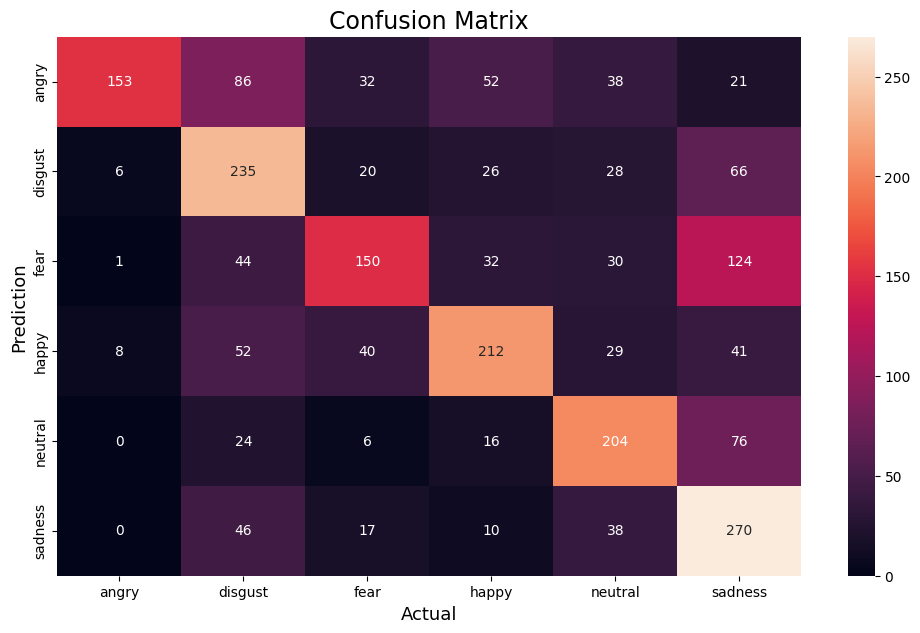

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#predict will return numpy array of aprobabiliesy for each instance in the sample 
y_pred = model.predict(test)
#choosing the max probabilty to determine the labels
y_pred = np.argmax(y_pred, axis=1)
y_check=np.argmax(test_labels,axis=1)
#confusion_matrix between the real and predicted from the model
conf=confusion_matrix(y_check,y_pred)
emotion_=np.unique(emotions)

plt.figure(figsize=(12,7))
sns.heatmap(conf,annot=True,fmt='g',xticklabels=[i for i in emotion_],yticklabels=[i for i in emotion_])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_check, y_pred)
print("Accuracy   :", accuracy)

Accuracy   : 0.5481415136587551


In [36]:
F1_score = f1_score(y_check, y_pred,pos_label='positive',average='micro')
print("F1-score  :", F1_score)

F1-score  : 0.5481415136587551


In [37]:
print("Precision Score : ",precision_score(y_check, y_pred,pos_label='positive',average='micro'))
print("Recall Score :" , recall_score(y_check, y_pred, pos_label='positive',average='micro') )

Precision Score :  0.5481415136587551
Recall Score : 0.5481415136587551
